In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Algorithmes d’apprentissage non supervisé<br>
    </h1>
    MovieLens - Système de recommendations de films<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle de La Sablonnière</b><br>
    <br>
    420-A58<br>
    <br>
</center>

# Introduction
    
Nous avons choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle décrit les notations des utilisateurs de MovieLens; un service de recommandations de films. Elle a été préalablement traité afin d'extraire les informations intéressantes pour un système de suggestions par clusterisation et règles d'associations. Les résultats se trouvent dans 2 fichiers. 

<br>**movies_pretraitement.csv**

Ce fichier contient les métadonnées pertinentes pour 1 film. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock"> movieId, imdbId, title, year, year_category, year_boxcox_std, rating_mode, genres, genres_tfidf_*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|imdbId| Identifiant du film dans [Internet Movie Database](http://www.imdb.com).|
|title| Titre du film. Peut contenir l'année de parution.|
|year| Année de parution du film.|
|year_category| **year** catégorisé. La base de données a 3 modalités.|
|year_boxcox_std| **year** transformé par BoxCox et StandardScaler.|
|rating_mode| Nombre d'étoiles attribuées avec une granularité de $\frac{1}{2}$. Entre [0.5 et 5] |
|genres| Liste de mots séparés par un 'pipe' (\|). La base de données a 18 modalités. |
|genres_tfidf_*| **genres** encodé selon TF-IDF. Ici l'étoile représente toutes les modalités de **genres**. |
</div>

<br>**ratings_pretraitement.csv**

Ce fichier contient les métadonnées de chaque film. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock">userId, films*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur.|
|films*| Identifiant du film. Ici l'étoile représente 1 colonne par film |
</div>

<br>

Chaque base de données sera examinée indépendemment. Nous allons d'abord valider les prétraitements. Par la suite, dans un but de restreindre la portée du projet, nous allons faire une *clusterization* sur (**genres**, **rating_mode**) et **genres_tfidf\***. Finalement nous allons examiner les règles d'associations avec **ratings_pretraitement.csv**.

In [32]:
#
# imports utilitaires
#

%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from fanalysis.base import Base
from fanalysis.mca import MCA
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud


#
# imports faisant partie de nos propres modules
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.jupyter as jup

# Lecteure des données

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

# imdbId doit etre garde en string (leading 0)
movies_df = pd.read_csv("dataset/movies_pretraitement.csv", dtype={"imdbId": str})

print("Movies", movies_df.shape)
print("Head")
display(movies_df.head().round(2))
clstr.show_types(movies_df)

Movies (9460, 26)
Head


,movieId,imdbId,title,year,year_category,year_boxcox_std,rating_mode,genres,genres_tfidf_Action,genres_tfidf_Adventure,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
0,1,0114709,Toy Story (1995),1995,"[1975, 2001]",-0.19,4.0,Animation|Comedy|Adventure|Children|Fantasy,0.0,0.41,...,0.48,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2,0113497,Jumanji (1995),1995,"[1975, 2001]",-0.19,4.0,Fantasy|Adventure|Children,0.0,0.51,...,0.59,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,3,0113228,Grumpier Old Men (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy|Romance,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0
3,4,0114885,Waiting to Exhale (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy|Romance|Drama,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.72,0.0,0.0,0.0,0.0
4,5,0113041,Father of the Bride Part II (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


Types


,movieId,imdbId,title,year,year_category,year_boxcox_std,rating_mode,genres,genres_tfidf_Action,genres_tfidf_Adventure,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
Type,int64,object,object,int64,object,float64,float64,object,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


* 9460 individus 
* 26 variables (elles correspondent bien à la description)
* **title**, **year_category** et **genres** sont de type qualitatif. Les autres variables sont de type quantitatif. Noter que **rating_mode** représente bien une variable qualitative par nature mais est gardé quantitatif pour faciliter certaines manipulations.

Nous allons vérifier les valeurs manquantes et doublons.

In [4]:
#
# validation valeurs manquantes doublons
#
print("Avant retrait doublons:", movies_df.shape)
movies_df.drop_duplicates(inplace=True)
print("Après retrait doublons:", movies_df.shape)

clstr.show_na(movies_df);

Avant retrait doublons: (9460, 26)
Après retrait doublons: (9460, 26)
Valeur manquante 0 (0.0%)


Aucun doublon et aucune valeur manquante. Nous allons vérifier les modalités des variables qualitatives.

In [5]:
#
# Verification des modalites (rating_mode est egalement inclu pour valider
# s'il correspond bien a sa description)
#
def get_mods(values, name=""):
    if isinstance(values, pd.Series):
        series = pd.Series(values.unique())
        series.name = values.name
    else:
        series = pd.Series(values)
        series.name = name
    
    return series.to_frame()

genres_ohe_df = movies_df.genres.str.get_dummies(sep=configs.dataset.genre_splitter)
genres_mods = get_mods(genres_ohe_df.columns, name="genres")

html_ = jup.horizontify(get_mods(movies_df.year_category),
                        get_mods(movies_df.rating_mode),
                        genres_mods)
print("Modalités")
jup.display_html(html_)

Modalités


,year_category
0,"[1975, 2001]"
1,"[1902, 1974]"
2,"[2002, 2018]"
,rating_mode
0,4.0
1,3.0
2,5.0
3,2.0
4,4.5
5,3.5


## Distributions - variables quantitatives

Stats générales - variables quantitatives


,count,mean,std,min,25%,50%,75%,max
year,9460.0,1994.64,18.38,1902.00,1988.00,1999.00,2008.00,2018.00
year_boxcox_std,9460.0,-0.00,1.00,-2.68,-0.61,0.08,0.79,1.78
rating_mode,9460.0,3.48,0.97,0.50,3.00,3.50,4.00,5.00
genres_tfidf_Action,9460.0,0.11,0.23,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Adventure,9460.0,0.07,0.20,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Animation,9460.0,0.04,0.16,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Children,9460.0,0.04,0.16,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Comedy,9460.0,0.24,0.34,0.00,0.00,0.00,0.47,1.00
genres_tfidf_Crime,9460.0,0.08,0.23,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Documentary,9460.0,0.04,0.20,0.00,0.00,0.00,0.00,1.00



Distributions - variables quantitatives


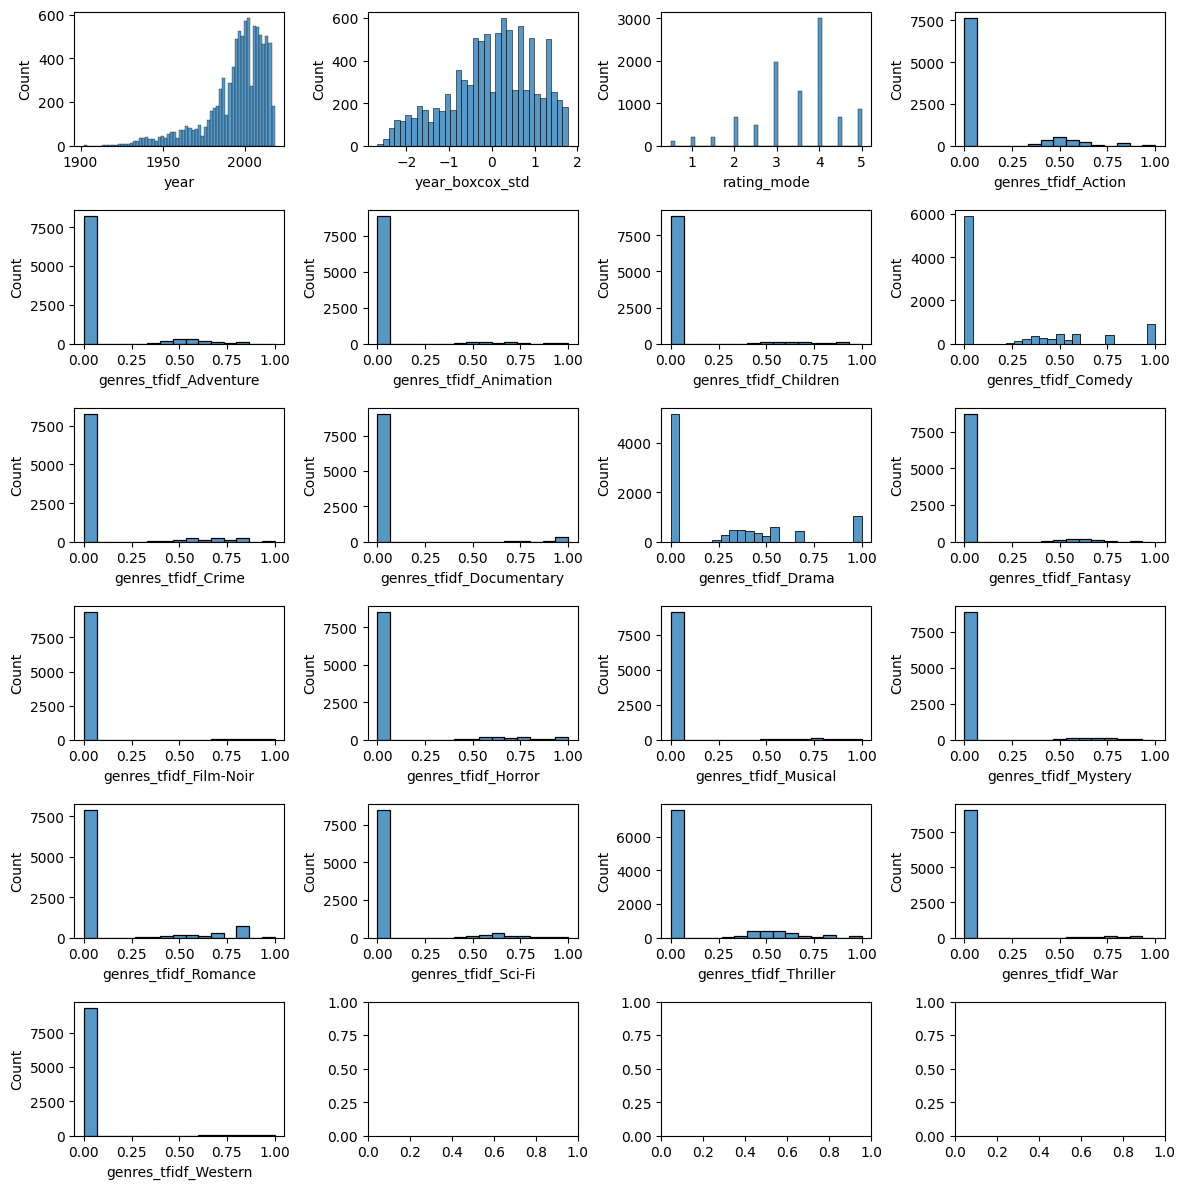

In [6]:
# on enleve movieId, imdbId et title
quant_df = movies_df.iloc[:, 3:].select_dtypes(exclude="object")

print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=4, figsize=(12, 12))

TODO: recopier analyse de l'autre notebook

* tf-idf est plein de 0 et devrait pas etre utiliser avec le numeriques
* sinon year_boxcox_std est ben correcte
* rating_mode est mieux dans qualitatif

# Valeurs aberrantes et *outliers* - variables quantitatives

IQR outliers par variable, eta: 1.5


,year,year_boxcox_std,rating_mode,genres_tfidf_Action,genres_tfidf_Adventure,genres_tfidf_Animation,genres_tfidf_Children,genres_tfidf_Comedy,genres_tfidf_Crime,genres_tfidf_Documentary,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
Count,562.0,0.0,310.0,1818.0,1239.0,573.0,626.0,0.0,1189.0,428.0,...,758.0,85.0,933.0,334.0,569.0,1562.0,964.0,1871.0,375.0,165.0
%,5.9,0.0,3.3,19.2,13.1,6.1,6.6,0.0,12.6,4.5,...,8.0,0.9,9.9,3.5,6.0,16.5,10.2,19.8,4.0,1.7



IQR outliers 7309 (77.3%), eta: 1.5

Outliers boxplots, eta: 1.5


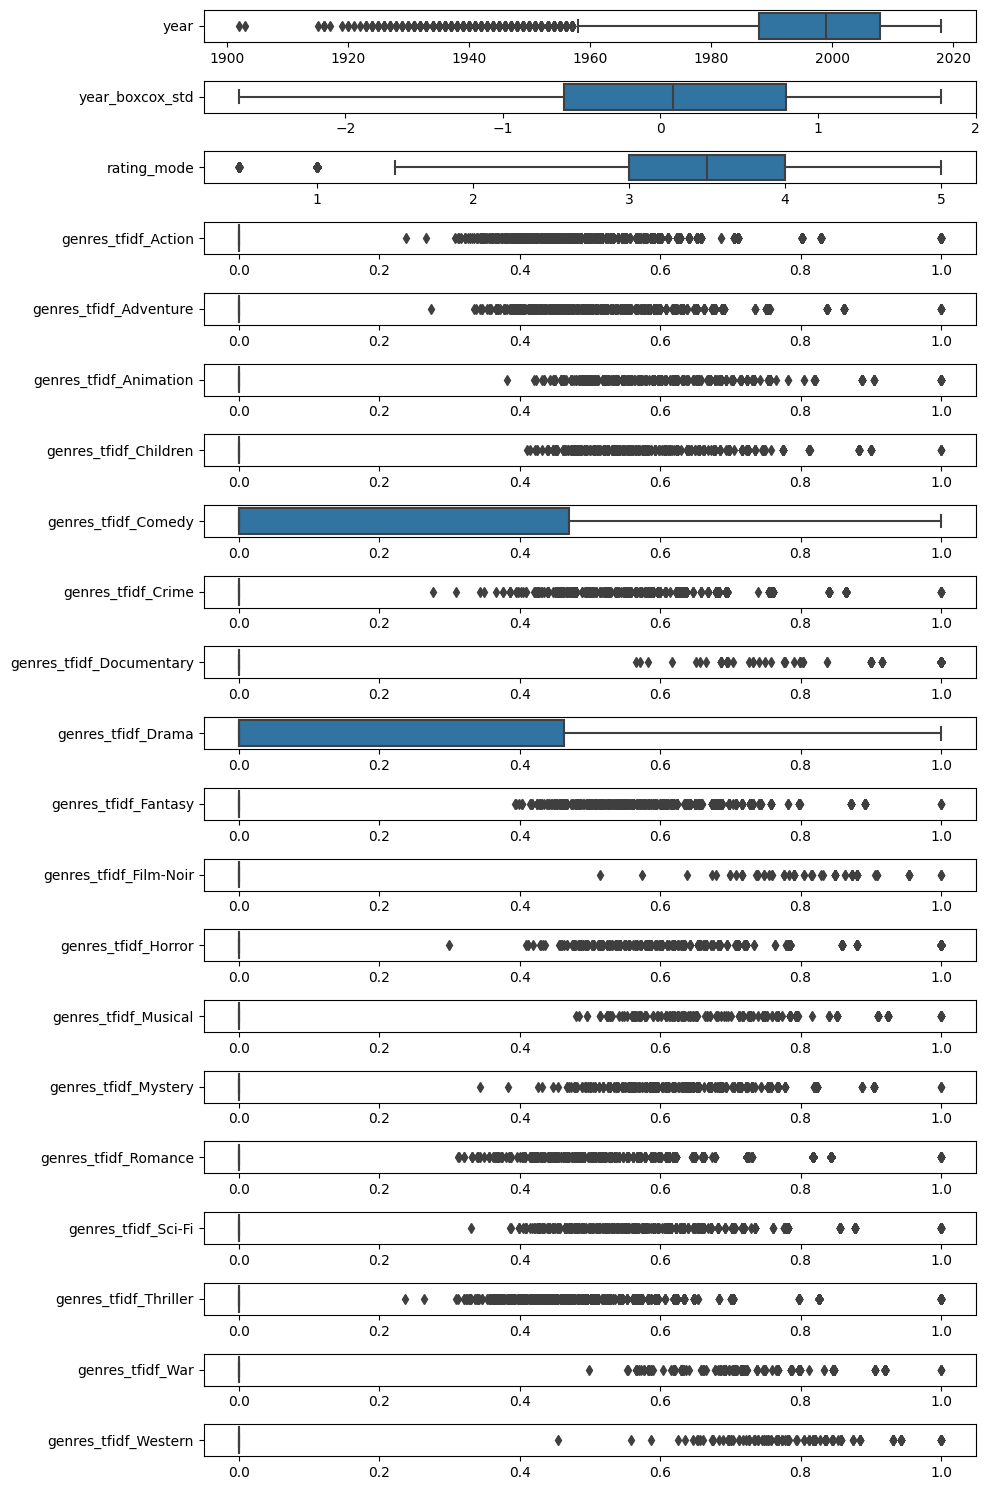

In [7]:
clstr.show_outliers_iqr(quant_df, 
                        eta=1.5,
                        boxlists=[[c] for c in quant_df.columns],
                        figsize=(10, 15));

Groso modo, year_boxcox_std est ok. Les outliers dans tf-idf ne le sont pas a notre avis. Le 0 bouge tout; présent à cause que les films ont un *set* réduit de genres. Les 1 sont présent à cause que tf-idf est normalisé et que certains films n'ont qu'un seul genre. Ca confirme notre intuition de separer. 

# Distributions - variables qualitatives

Distributions - variables qualitatives


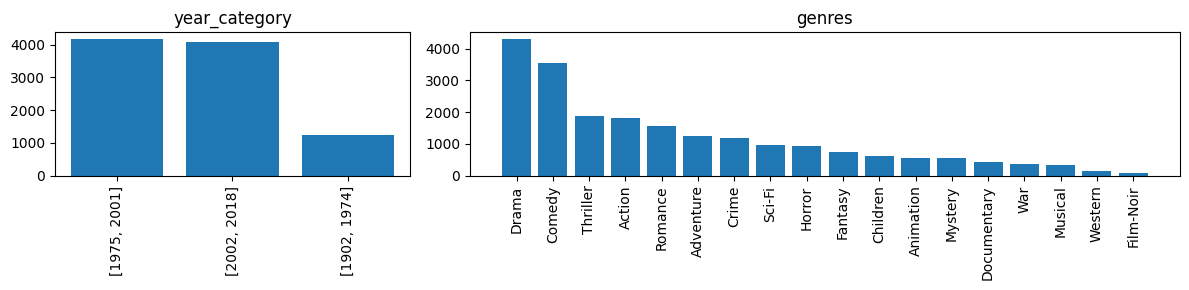

In [8]:
year_category_count = movies_df.year_category.value_counts()
genres_count = genres_ohe_df.sum(axis=0)
genres_count.sort_values(ascending=False, inplace=True)

print("Distributions - variables qualitatives")

_, axes = plt.subplots(1, 
                       2, 
                       width_ratios=[1, 2],
                       figsize=(12, 3))
axes[0].bar(year_category_count.index, year_category_count)
axes[0].tick_params(axis="x", labelrotation=90)
axes[0].set_title("year_category")

axes[1].bar(genres_count.index, genres_count)
axes[1].tick_params(axis="x", labelrotation=90)
axes[1].set_title("genres")
             
plt.tight_layout()
plt.show()

* Forte proportion dans Drama et Comedy

# Corrélation

In [9]:
#
# utilitaires pour calculer chi2 (correlation avec variables qualitatives)
#
def genres_contingency(b, data, genres_modalites):
    """
    Utilitaire pour calculer la table de contingence sachant que genres est implique
    Pandas.crosstab() ne fonctionne pas avec genres
    """
    def _genres_crit(data, modality):
        return data.str.contains(fr"\b{modality}\b", case=True, regex=True)
    
    def _default_crit(data, modality):
        return data == modality
    
    if b == "genres":
        other_crit_ = _genres_crit
        other = data.genres
        other_modalities = genres_modalites
    else:
        other_crit_ = _default_crit
        other = data[b]
        other_modalities = other.unique()
    
    ct = pd.DataFrame(0, 
                      index=genres_modalites, 
                      columns=other_modalities)

    for m0 in genres_modalites:
        genres_crit = _genres_crit(data.genres, m0)
        
        for m1 in other_modalities:
            other_crit = other_crit_(other, m1)
            ct.loc[m0, m1] = np.count_nonzero(genres_crit & other_crit)
        
    return ct

def chi2(a, b, df, genres_modalites):
    """
    Encapsule le calcul de chi2 pour tenir compte de genres
    """
    if a == "genres":
        contingency = genres_contingency(b, df, genres_modalites)
    elif b == "genres":
        contingency = genres_contingency(a, df, genres_modalites).T
    else:
        contingency = pd.crosstab(df[a], df[b])
        
    chi2_, pvalue, _, _ = chi2_contingency(contingency)
    return chi2_, pvalue

def chi2_analysis(data, chi2_columns, genres_modalites):
    """
    Encapsule analyse chi2. Assumer que chi2_columns ne contient que 
    des variables qualitatives.
    """
    chi2_df = pd.DataFrame(np.nan, 
                           index=chi2_columns, 
                           columns=chi2_columns)
    chi2_pvalue_df = pd.DataFrame(np.nan, 
                                  index=chi2_columns, 
                                  columns=chi2_columns)

    for c0 in chi2_columns:
        for c1 in chi2_columns:
            prev = chi2_df.loc[c1, c0]
            if math.isnan(prev):
                prev, prev_pvalue = chi2(c0, 
                                         c1, 
                                         data,
                                         genres_modalites)
            else:
                prev_pvalue = chi2_pvalue_df.loc[c1, c0]

            chi2_df.loc[c0, c1] = prev
            chi2_pvalue_df.loc[c0, c1] = prev_pvalue

    chi2_styler = jup.caption_df(chi2_df.style, r"$\chi^2$", caption_bold=False)
    pvalue_styler = jup.caption_df(chi2_pvalue_df.style, "$p_{value}$", caption_bold=False)
    corr_html = jup.horizontify(chi2_styler, pvalue_styler)

    print("Analyse indépendance de:", chi2_columns)
    jup.display_html(corr_html)

In [10]:
chi2_analysis(movies_df,
              ["year_category", "rating_mode", "genres"], 
              genres_mods.genres)

Analyse indépendance de: ['year_category', 'rating_mode', 'genres']


,year_category,rating_mode,genres
year_category,18920.000000,849.911482,934.048473
rating_mode,849.911482,85140.000000,801.501340
genres,934.048473,801.501340,134711.974950
,year_category,rating_mode,genres
year_category,0.000000,0.000000,0.000000
rating_mode,0.000000,0.000000,0.000000
genres,0.000000,0.000000,0.000000


On voit que $p_{value}$ est < 0.05. On rejète l'hypothèse nulle (indépendance). Les variables sont donc dépendantes. On assume donc que clustering peut avoir un certain sens. Noter que la réduction de dimension n'est probablement pas en lien avec la corrélation ici.

Corrélation genres tfidf


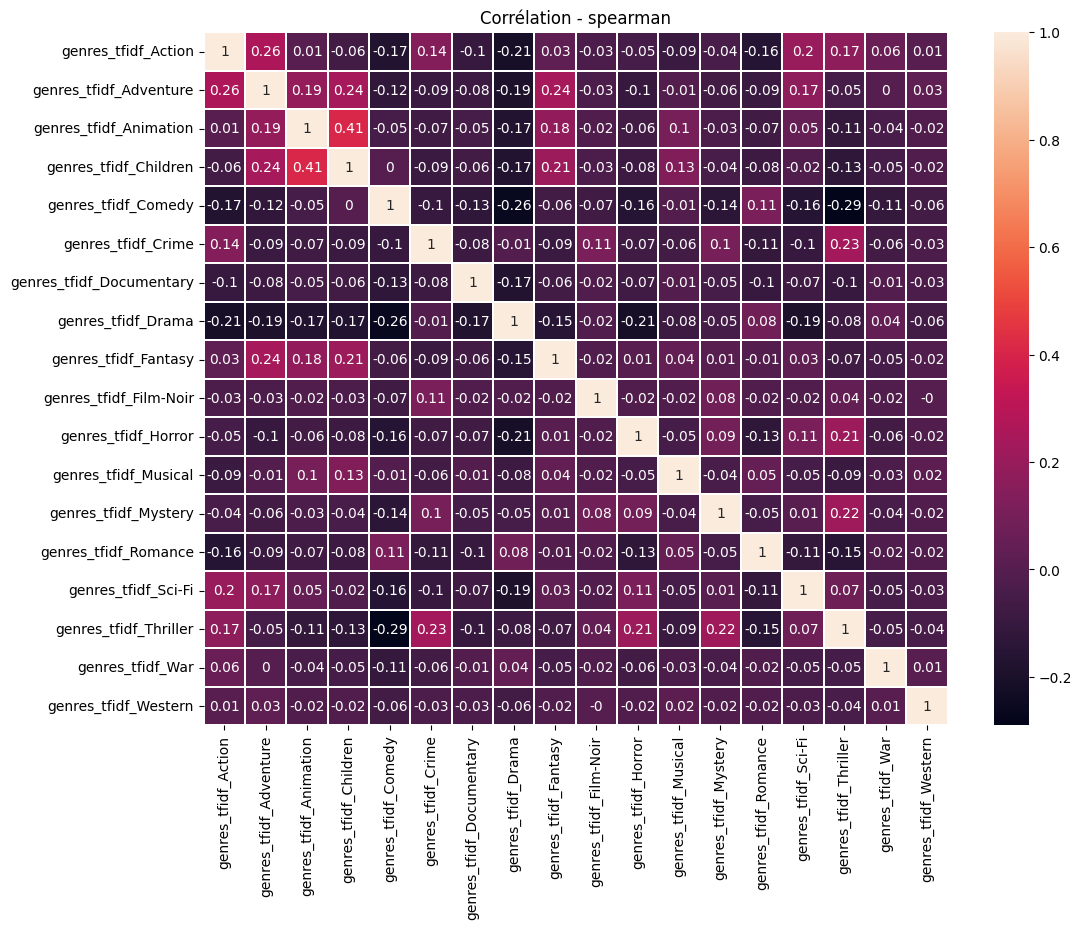

In [11]:
genres_tfidf_cols = movies_df.columns.str.contains("genres_tfidf_")
genres_tfidf_cols = movies_df.columns[genres_tfidf_cols]
genres_tfidf_df = movies_df[genres_tfidf_cols]

print("Corrélation genres tfidf")
clstr.show_correlation(genres_tfidf_df,
                       method="spearman", 
                       figsize=(12, 9))

On observe aucune corrélation à toute fin pratique (majorités des valeurs < |0.2|). On pourrait croire que la réduction de dimension ne serait pas utilile mais noter la présence de beaucoup de 0 dans les distributions. Nous allons valider plus loin dans le notebook.

TODO: repeter correlaton forte avec animation et avanture?


# Réduction de dimensions et clustering
## (genres, rating_mode)

In [12]:
#
# l'encodage de genres ne peut se faire par fanalysis
# de plus, fanalysis ne permet pas de passer notre propre one hot encoder
# donc, ajouter ces classes pour ajouter cette fonctionalite
#

class MCA_from_dummies(Base):
    def __init__(self, n_components=None, row_labels=None, var_labels=None, stats=True):
        Base.__init__(self, n_components, row_labels, None, stats)
        self.var_labels = var_labels
        
    def prefit(self, X, X_dummies):
        # Set columns prefixes
        self.n_vars_ = X.shape[1]
        self.prefixes_ = self.prefixes_ = [str(x) + "_" for x in self.var_labels]
        self.col_labels_short_temp_ = [x.split("_")[-1] for x in X_dummies.columns]
        self.col_labels_temp_ = X_dummies.columns
                
        # Dummy variables creation
        self.n_categories_ = X_dummies.shape[1]
    
    def fit(self, X_dummies, y=None):
        # Fit a Factorial Analysis to the dummy variables table
        self.r_ = np.sum(X_dummies, axis=1).reshape(-1, 1)
        Base.fit(self, X_dummies, y=None)
        
        # Adjustment of the number of components
        n_eigen = self.n_categories_ - self.n_vars_
        if (self.n_components_ > n_eigen):
            self.n_components_ = n_eigen
            self.eig_ = self.eig_[:, :self.n_components_]
            self.row_coord_ = self.row_coord_[:, :self.n_components_]
            self.col_coord_ = self.col_coord_[:, :self.n_components_]
            if self.stats:
                self.row_contrib_ = self.row_contrib_[:, :self.n_components_]
                self.col_contrib_ = self.col_contrib_[:, :self.n_components_]
                self.row_cos2_ = self.row_cos2_[:, :self.n_components_]
                self.col_cos2_ = self.col_cos2_[:, :self.n_components_]

        # Set col_labels_short_
        self.col_labels_short_ = self.col_labels_short_temp_
        
        # Set col_labels_
        self.col_labels_ = self.col_labels_temp_        
        
        self.model_ = "mca"
        
        return self
                        
def acm_init(data, n_components, data_dummies=None):
    if data_dummies is None:
        acm = MCA(n_components=n_components,
                  row_labels=data.index,
                  var_labels=data.columns)
        acm.fit(data.to_numpy())
    else:
        acm = MCA_from_dummies(n_components=n_components,
                               row_labels=data.index,
                               var_labels=data.columns)
        
        acm.prefit(data, data_dummies)        
        acm.fit(data_dummies.to_numpy())
    
    return acm

def acm_analysis(data, data_dummies=None, figsize=(4, 2.5)):
    """
    Le threshold est ~60% sur cumul var. expliquee
    """
    acm = acm_init(data, None, data_dummies=data_dummies)

    threshold = 1 / acm.n_vars_
    eig_vals = acm.eig_[0]
    eig_th = eig_vals[eig_vals > threshold]

    print("Valeurs propres:")
    print(acm.eig_[0].round(4))
    print()
    print(f"Valeurs propres > {round(threshold, 4)} (1 / p):")
    print(eig_th.round(4))
    print()
    print("Variance expliquee %:")
    print(acm.eig_[1].round(1))
    print()
    print("Variance expliquee cumul. %:")
    print(acm.eig_[2].round(1))
    print()

    num_eigval = len(acm.eig_[0])

    plt.figure(figsize=figsize)
    plt.plot(range(1, num_eigval + 1), acm.eig_[0], marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("Valeur propre")
    plt.show()

Valeurs propres:
[0.4983 0.4449 0.4247 0.3783 0.3557 0.3496 0.3474 0.3461 0.344  0.3416
 0.3387 0.336  0.307  0.2879 0.2851 0.261  0.2393 0.2329 0.2206 0.2004
 0.1948 0.1794 0.1553 0.1423 0.1386 0.1192]

Valeurs propres > 0.5 (1 / p):
[]

Variance expliquee %:
[6.6 5.9 5.7 5.  4.7 4.7 4.6 4.6 4.6 4.6 4.5 4.5 4.1 3.8 3.8 3.5 3.2 3.1
 2.9 2.7 2.6 2.4 2.1 1.9 1.8 1.6]

Variance expliquee cumul. %:
[ 6.6 12.6 18.2 23.3 28.  32.7 37.3 42.  46.5 51.1 55.6 60.1 64.2 68.
 71.8 75.3 78.5 81.6 84.6 87.2 89.8 92.2 94.3 96.2 98.1 99.6]



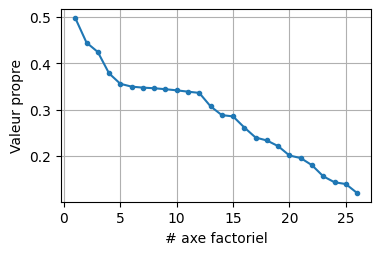

In [13]:
#
# faire le one hot encodage nous meme
#
rating_mode_ohe = movies_df.rating_mode.astype(str).str.get_dummies()

acm_data_ohe_df = pd.concat([rating_mode_ohe, genres_ohe_df], axis=1)
acm_data_df = movies_df[["rating_mode", "genres"]]

acm_analysis(acm_data_df, data_dummies=acm_data_ohe_df)

La règle de Kaiser adaptée à l'ACM ne fonctionne pas ici; 2 variables. Le graphe montre présence de 2 coudes: à 5 et 12 axes factoriels. 5 axes donnent ~28% de variance expliquée et 12 donne ~60%. On garde donc 12 axes.

(genres, rating_mode) ACM - Visualisation dimensions


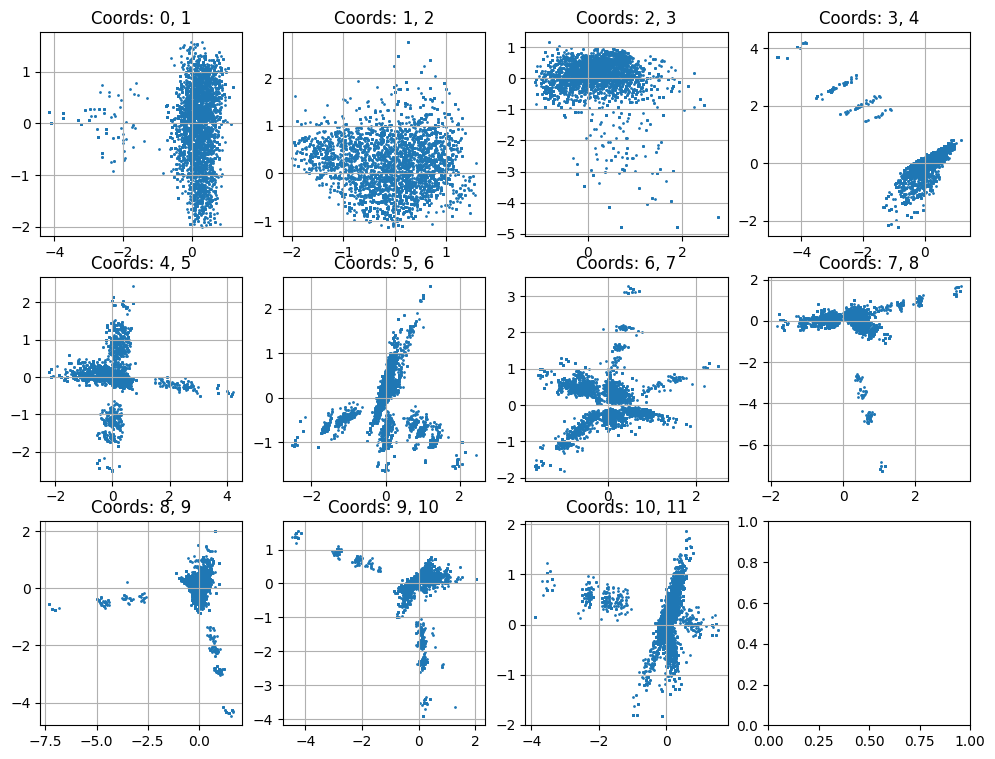

In [14]:
acm_ = acm_init(acm_data_df, 12, data_dummies=acm_data_ohe_df)

print("(genres, rating_mode) ACM - Visualisation dimensions")
clstr.scatter_multiplot(acm_.row_coord_, num_cols=4, figsize=(12, 9), marker_size=1)

TODO: interpretation

(genres, rating_mode) ACM - KMeans clustering


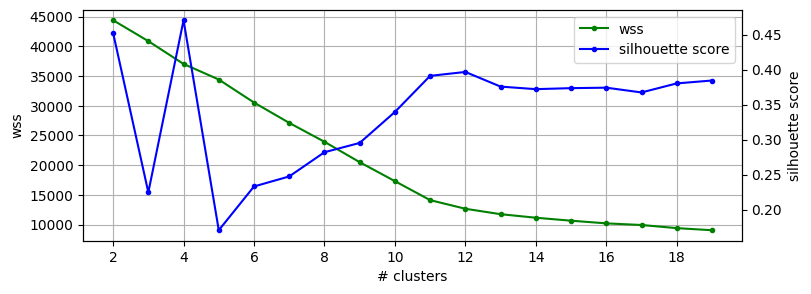

In [15]:
print("(genres, rating_mode) ACM - KMeans clustering")
clstr.kmeans_analysis(acm_.row_coord_, 
                      clusters_range=range(2, 20),
                      figsize=(8.5, 3))

Le graphe suggère 12 *clusters*. silhouette_score maxumum avec inertie minimale.

(genres, rating_mode) ACM - Visualisation clusters KMeans


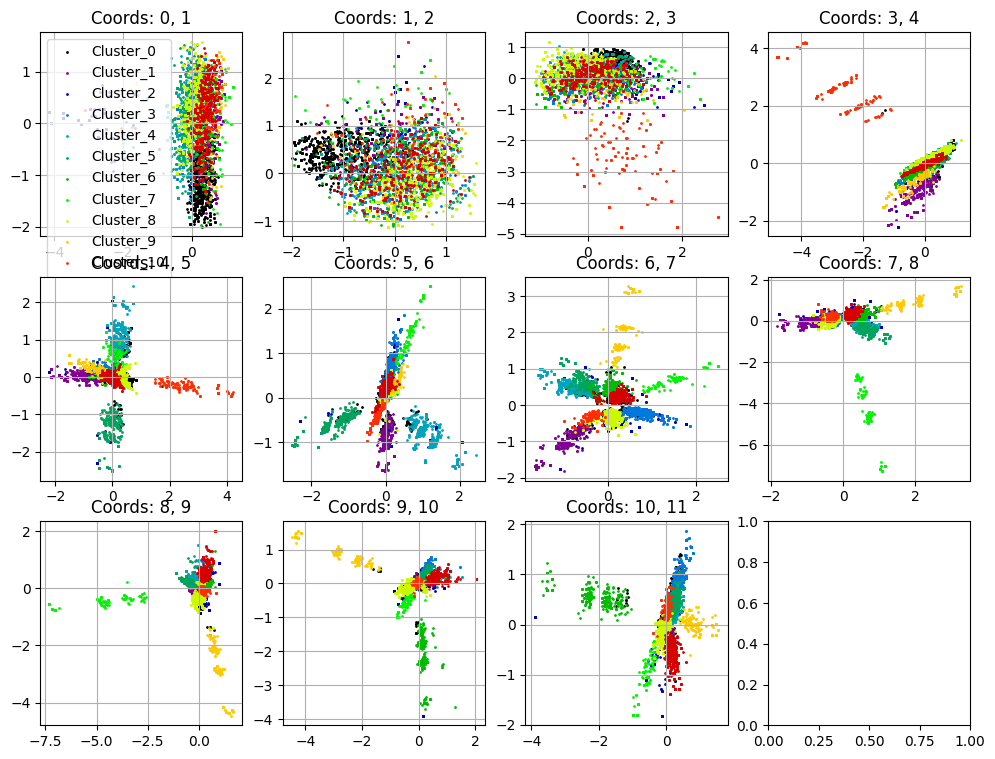

In [69]:
kmeans_ = clstr.kmeans_init(acm_.row_coord_, 12)

print("(genres, rating_mode) ACM - Visualisation clusters KMeans")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=4, 
                        figsize=(12, 8), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

In [81]:
def acm_cluster_agg(group):
    return group.sum(axis=0)

def acm_cluster_analysis(group, rating_count=2, genres_count=5):
    # on sait que rating sont les 10 premieres colones
    ratings = group.iloc[:10]

    # ne prendre les ratings qui sont present dans le cluster
    ratings = ratings[ratings > 0]
    
    # garder les ratings plus importants
    top_ratings = ratings.argsort()[-rating_count:][::-1]
    top_ratings = ratings.index[top_ratings].to_list()
    top_ratings = "|".join([str(r) for r in top_ratings])
    
    # meme processus que ratings pour genres
    genres = group.iloc[10:]
    genres = genres[genres > 0]
    
    top_genres = genres.argsort()[-genres_count:][::-1]
    top_genres = genres.index[top_genres].to_list()
    top_genres = "|".join(top_genres)
    
    return pd.Series({"top_rating": top_ratings, "top_genres": top_genres})

def acm_word_clouds(group):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        ratings = group.iloc[:10]
        ratings = ratings[ratings > 0]
        ratings_cloud = WordCloud().generate_from_frequencies(ratings)

        genres = group.iloc[10:]
        genres = genres[genres > 0]
        genres_cloud = WordCloud().generate_from_frequencies(genres)

    return pd.Series({"rating_word_cloud": ratings_cloud.to_array(), 
                      "genre_word_cloud": genres_cloud.to_array()})

def show_word_clouds(cluster_data_df, num_cols, figsize):
    #
    # examiner en wordcloud
    #
    wc = cluster_data_df.apply(acm_word_clouds, axis=1)
    num_rows = math.ceil(wc.shape[0] / num_cols)

    plt.figure(figsize=figsize)

    index = 1
    num_cols *= 2
    for x in range(acm_kmeans_wc.shape[0]):
        plt.subplot(num_rows, num_cols, index + 0)
        if (x // num_cols)  == 0:
            plt.title("rating_mode")
        plt.gca().set_ylabel(f"Cluster {index // 2}")
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(wc.iloc[x, 0])

        plt.subplot(num_rows, num_cols, index + 1)
        if (x // num_cols) == 0:
            plt.title("genres")
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(wc.iloc[x, 1])

        index += 2

    plt.tight_layout()
    plt.show()

def show_acm_cluster_analysis(ohe_df, labels, num_cols=3, figsize=(10, 5)):
    clusters_df = ohe_df.groupby(labels).agg(acm_cluster_agg)
    if False:
        display(clusters_df)

    cluster_data_df = clusters_df.apply(acm_cluster_analysis, axis=1)
    display(cluster_data_df)
    
    show_word_clouds(clusters_df, num_cols, figsize)

(genres, rating_mode) ACM - Analyse clusters KMeans
Davies Bouldin score: 0.8343

Silhouette score: 0.3966
Silhouette score par cluster
[0.1999, 0.4118, 0.3318, 0.4035, 0.4355, 0.4371, 0.4593, 0.5223, 0.4466, 0.5006, 0.5117, 0.3671]


(genres, rating_mode) ACM - Analyse contenu clusters KMeans


,top_rating,top_genres
0,4.0|3.0,Adventure|Children|Animation|Action|Fantasy
1,2.0,Comedy|Drama|Thriller|Action|Horror
2,4.0|3.5,Documentary|Comedy|Drama|Musical|War
3,3.5,Drama|Comedy|Romance|Thriller|Action
4,5.0,Drama|Comedy|Romance|Action|Thriller
5,4.5,Drama|Comedy|Thriller|Romance|Action
6,2.5,Comedy|Drama|Thriller|Action|Crime
7,0.5,Comedy|Drama|Horror|Action|Sci-Fi
8,4.0|2.0,Drama|Comedy|Thriller|Romance|Crime
9,1.5,Comedy|Drama|Thriller|Action|Horror


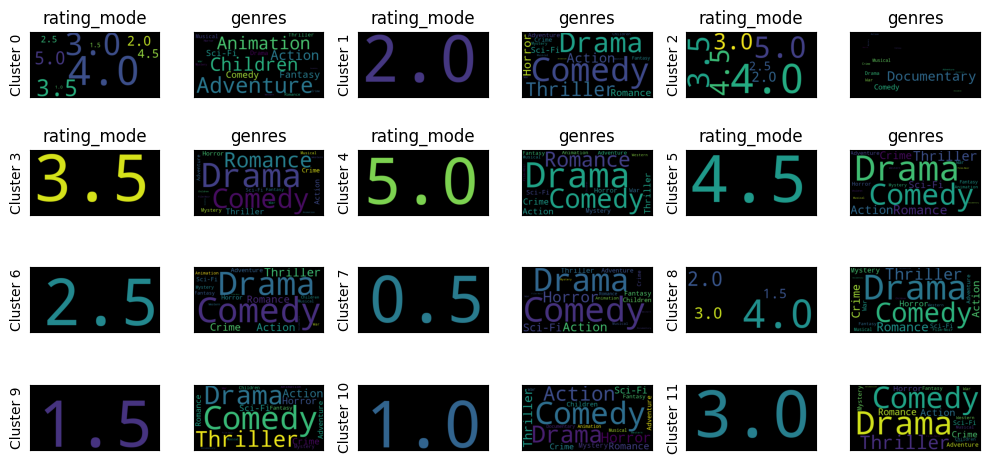

In [82]:
print("(genres, rating_mode) ACM - Analyse clusters KMeans")
clstr.clusters_analysis(acm_.row_coord_, kmeans_.labels_)

print()

print("(genres, rating_mode) ACM - Analyse contenu clusters KMeans")
show_acm_cluster_analysis(acm_data_ohe_df, 
                          kmeans_.labels_, 
                          num_cols=3)

## genres_tfidf*

In [ ]:

# tsvd_sample = TruncatedSVD(n_components=18)
# tsvd_sample_df = tsvd_sample.fit_transform(genres_tfidf_df)
# ss = np.cumsum(tsvd_sample.explained_variance_ratio_)

# plt.figure(figsize=(4, 2.5))
# plt.plot(range(1, ss.shape[0] + 1), ss, marker=".")
# plt.grid(True)
# plt.show()

# plt.scatter(tsvd_sample_df[:, 0], tsvd_sample_df[:, 1], s=0.5)
# plt.show()

In [ ]:
frac = 0.1

mds_data_df = genres_ohe_df.sample(frac=frac)
# mds_data_df = genres_tfidf_df.sample(frac=frac)

distances = pairwise_distances(mds_data_df, metric="cosine", n_jobs=-1)

In [ ]:
mds_ = MDS(n_components=2, 
           dissimilarity="precomputed", 
           normalized_stress=False,
           n_jobs=-1)

with hlp.Profile() as mds_profile:
    coords = mds_.fit_transform(distances)

print("MDS:", mds_profile.round_duration(2), "s")
plt.scatter(coords[:, 0], coords[:, 1], s=0.5)
plt.show()

In [ ]:
# tsvd_sample = TruncatedSVD(n_components=genres_ohe_df.shape[1])
# tsvd_sample_df = tsvd_sample.fit_transform(genres_ohe_df)
# ss = np.cumsum(tsvd_sample.explained_variance_ratio_)

# plt.figure(figsize=(4, 2.5))
# plt.plot(range(1, ss.shape[0] + 1), ss, marker=".")
# plt.grid(True)
# plt.show()

# plt.scatter(tsvd_sample_df[:, 0], tsvd_sample_df[:, 1], s=0.5)
# plt.show()